# Bibliotecas

In [2]:
from obterDados import obterSimbolo
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from pickle import dump, load

# Obtendo dados

In [2]:
rawDataM5 = obterSimbolo('WDO$N')
rawDataM5

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2020-01-02 14:25:00,4041.0,4041.5,4039.5,4040.0,2576,500,11609
2020-01-02 14:30:00,4040.0,4041.0,4038.0,4038.5,1539,500,6374
2020-01-02 14:35:00,4038.5,4040.0,4036.0,4036.5,2936,500,12038
2020-01-02 14:40:00,4037.0,4038.0,4035.5,4036.0,2098,500,8757
2020-01-02 14:45:00,4036.0,4038.0,4035.0,4036.0,2087,500,7680
...,...,...,...,...,...,...,...
2023-08-31 16:40:00,4972.5,4972.5,4969.0,4970.0,885,0,12824
2023-08-31 16:45:00,4970.5,4971.0,4968.0,4969.0,933,0,12207
2023-08-31 16:50:00,4969.5,4972.0,4967.0,4968.0,1132,0,23659


In [3]:
rawDataM5[:-252*108]

,open,high,low,close,tick_volume,spread,real_volume
time,,,,,,,
2020-01-02 14:25:00,4041.0,4041.5,4039.5,4040.0,2576,500,11609
2020-01-02 14:30:00,4040.0,4041.0,4038.0,4038.5,1539,500,6374
2020-01-02 14:35:00,4038.5,4040.0,4036.0,4036.5,2936,500,12038
2020-01-02 14:40:00,4037.0,4038.0,4035.5,4036.0,2098,500,8757
2020-01-02 14:45:00,4036.0,4038.0,4035.0,4036.0,2087,500,7680
...,...,...,...,...,...,...,...
2022-09-02 10:30:00,5227.0,5238.0,5225.5,5237.5,21115,500,62033
2022-09-02 10:35:00,5237.0,5242.5,5232.0,5237.0,23744,500,67119
2022-09-02 10:40:00,5237.5,5249.5,5237.0,5246.0,20683,500,56959


In [4]:
rawDataM5 = rawDataM5.drop(columns=['spread'])
rawDataM5['minute'] = rawDataM5.index.minute
rawDataM5['hour'] = rawDataM5.index.hour
rawDataM5['day_of_week'] = rawDataM5.index.day_of_week
rawDataM5['day'] = rawDataM5.index.day
rawNP = rawDataM5.to_numpy()
rawNP

array([[4.0410e+03, 4.0415e+03, 4.0395e+03, ..., 1.4000e+01, 3.0000e+00,
        2.0000e+00],
       [4.0400e+03, 4.0410e+03, 4.0380e+03, ..., 1.4000e+01, 3.0000e+00,
        2.0000e+00],
       [4.0385e+03, 4.0400e+03, 4.0360e+03, ..., 1.4000e+01, 3.0000e+00,
        2.0000e+00],
       ...,
       [4.9695e+03, 4.9720e+03, 4.9670e+03, ..., 1.6000e+01, 3.0000e+00,
        3.1000e+01],
       [4.9685e+03, 4.9730e+03, 4.9675e+03, ..., 1.6000e+01, 3.0000e+00,
        3.1000e+01],
       [4.9725e+03, 4.9725e+03, 4.9715e+03, ..., 1.7000e+01, 3.0000e+00,
        3.1000e+01]])

# Tratamento de Dados

### Gerando colunas com preços passados

In [5]:
nPassado = 1000
nFuturo = 24
histNp = np.zeros((len(rawNP)-(nPassado+nFuturo), nPassado, rawDataM5.shape[1]))
for i in tqdm(range(len(histNp))):
    histNp[i] = rawNP[i:i+nPassado]

100%|██████████| 98975/98975 [00:13<00:00, 7559.35it/s] 


### Achar quando comprar, vender ou fazer nada

In [6]:
pontos = 30
y = np.zeros((len(histNp)))
# y[:, 0] = 1
for i in tqdm(range(len(y))):
    ultimoPreco = histNp[i, -1, 3]
    for j in range(nFuturo):
        # nao fazer nada se for mais de 14hs
        # if rawNP[nPassado+i+j, -3] > 14:
        #     break
        # comprar
        if rawNP[nPassado+i+j, 1] >= ultimoPreco + pontos:
            y[i] = 1
            break
        # vender
        if rawNP[nPassado+i+j, 2] <= ultimoPreco - pontos:
            y[i] = 2
            break


100%|██████████| 98975/98975 [00:11<00:00, 8707.83it/s] 


### Normalização

In [7]:
histNpNorm = np.zeros(histNp.shape, dtype=np.float16)
for i in tqdm(range(len(histNpNorm))):
    # preços
    vmax = histNp[i, :, :4].max()
    vmin = histNp[i, :, :4].min()
    histNpNorm[i, :, :4] = (histNp[i, :, :4] - vmin) / (vmax - vmin)
    # tick volume
    vmax = histNp[i, :, 4].max()
    vmin = histNp[i, :, 4].min()
    histNpNorm[i, :, 4] = (histNp[i, :, 4] - vmin) / (vmax - vmin)
    # real volume
    vmax = histNp[i, :, 5].max()
    vmin = histNp[i, :, 5].min()
    histNpNorm[i, :, 5] = (histNp[i, :, 5] - vmin) / (vmax - vmin)
    # minuto
    histNpNorm[i, :, 6] = histNp[i, :, 6] / 60
    # hora
    histNpNorm[i, :, 7] = histNp[i, :, 7] / 24
    # dia da semana
    histNpNorm[i, :, 8] = histNp[i, :, 8] / 4
    # dia
    histNpNorm[i, :, 9] = histNp[i, :, 9] / 31


100%|██████████| 98975/98975 [01:19<00:00, 1239.55it/s]


### Reshape para 2d

In [8]:
x = np.reshape(histNpNorm, (histNpNorm.shape[0], histNpNorm.shape[1] * histNpNorm.shape[2]))

### Balanceamento de Classes

[56965 20596 21414]


([<matplotlib.patches.Wedge at 0x130a97c7be0>,
 [Text(-0.25863552812199975, 1.069162131574559, '0.0'),
  Text(-0.47088319112060734, -0.9941172065305347, '1.0'),
  Text(0.8555321028593509, -0.6914223173842865, '2.0')])

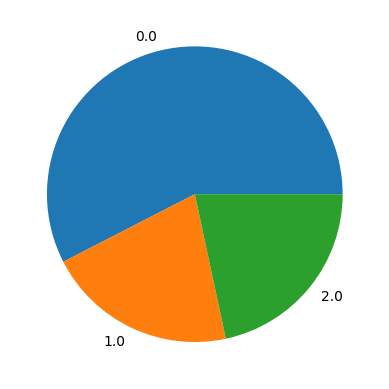

In [9]:
unicos, contagem = np.unique(y, return_counts=True)
print(contagem)
plt.pie(contagem, labels=unicos)

[20596 20596 20596]


([<matplotlib.patches.Wedge at 0x130aa0fc970>,
 [Text(0.5499999702695115, 0.9526279613277875, '0.0'),
  Text(-1.0999999999999954, -1.0298943258065002e-07, '1.0'),
  Text(0.5500001486524352, -0.9526278583383436, '2.0')])

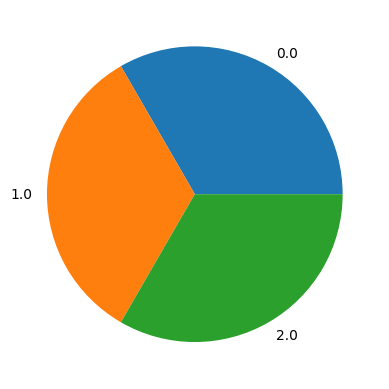

In [10]:
amostra = contagem.min()
Amostragem = np.zeros((amostra * 3, x.shape[1] + 1), dtype=np.float16)

for i in range(3):
    xClasse_i = x[y == i]
    xAmostra = xClasse_i[np.random.choice(xClasse_i.shape[0], size=amostra, replace=False)]
    Amostragem[i*amostra:(i+1)*amostra, :-1] = xAmostra
    Amostragem[i*amostra:(i+1)*amostra, -1] = i

np.random.shuffle(Amostragem)
x = Amostragem[:, :-1]
y = Amostragem[:, -1]

unicos, contagem = np.unique(y, return_counts=True)
print(contagem)
plt.pie(contagem, labels=unicos)

### Separar dados de treino e teste

In [11]:
# from sklearn.model_selection import train_test_split

# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

In [12]:
np.save(open('data/x.npy', 'wb'), x)
np.save(open('data/y.npy', 'wb'), y)

In [3]:
x = np.float16(np.load(open('data/x.npy', 'rb')))
y = np.float16(np.load(open('data/y.npy', 'rb')))

# Criar Modelo

### Lazy Classifier

In [ ]:
# from lazypredict.Supervised import LazyClassifier
# from sklearn.model_selection import train_test_split
# import numpy as np

# lazyReg = LazyClassifier()
# x = np.load(open('data/x.npy', 'rb'))
# y = np.load(open('data/y.npy', 'rb'))
# x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1)
# results, models = lazyReg.fit(x_train, x_test, y_train, y_test)
# results

### Criando modelos

In [5]:
from xgboost import XGBClassifier

modelo = XGBClassifier(objective="multi:softprob")
modelo.fit(x, y)
dump(modelo, open(f'models/modeloClassificadorXGBoost{str(x.shape[1])}.pickle', 'wb'))

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier

modelo = ExtraTreesClassifier()
modelo.fit(x, y)
dump(modelo, open(f'models/modeloClassificadorExtraTrees{str(x.shape[1])}.pickle', 'wb'))

In [ ]:
# from sklearn.svm import SVC

# modelo = SVC()
# modelo.fit(x_train, y_train)
# dump(modelo, open(f'models/modeloClassificadorSVC{str(x.shape[1])}.pickle', 'wb'))

# Pontuação de treino e teste

In [ ]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

modelo = load(open(f'models/modeloClassificadorExtraTrees10000.pickle', 'rb'))

In [ ]:
print(classification_report(y, modelo.predict(x)))

In [ ]:
print(classification_report(y_train, modelo.predict(x_train)))

In [ ]:
print(classification_report(y_test, modelo.predict(x_test)))

In [ ]:
ConfusionMatrixDisplay.from_estimator(modelo, x, y)

In [ ]:
ConfusionMatrixDisplay.from_estimator(modelo, x_train, y_train)

In [ ]:
ConfusionMatrixDisplay.from_estimator(modelo, x_test, y_test)

# Teste Finaceiro

In [ ]:
from json import dumps

target = 30
stop = 10
timeLimit = 24
total = 0
long = False
short = False
position = 0
candle = -1
operacoes = {
    'longSuccess' : [0, 0],
    'longFail' : [0, 0],
    'longEndSuccess' : [0, 0],
    'longEndFail' : [0, 0],
    'shortSuccess' : [0, 0],
    'shortFail' : [0, 0],
    'shortEndSuccess' : [0, 0],
    'shortEndFail' : [0, 0],
}
for i in tqdm(range(252*108, -1, -1)):
    dados = obterSimbolo('WDO$N', n=1000, delayCandles=i)
    hist = dados.copy().drop(columns=['spread'])
    hist['minute'] = hist.index.minute
    hist['hour'] = hist.index.hour
    hist['day_of_week'] = hist.index.day_of_week
    hist['day'] = hist.index.day
    histNP = hist.to_numpy()
    vmax = histNP[:, :4].max()
    vmin = histNP[:, :4].min()
    histNP[:, :4] = (histNP[:, :4] - vmin) / (vmax - vmin)
    vmax = histNP[:, 4].max()
    vmin = histNP[:, 4].min()
    histNP[:, 4] = (histNP[:, 4] - vmin) / (vmax - vmin)
    vmax = histNP[:, 5].max()
    vmin = histNP[:, 5].min()
    histNP[:, 5] = (histNP[:, 5] - vmin) / (vmax - vmin)
    histNP[:, 6] /= 60
    histNP[:, 7] /= 24
    histNP[:, 8] /= 4
    histNP[:, 9] /= 31
    priceNow = hist['close'].iloc[-1]
    if long:
        if priceNow >= position + target:
            total += priceNow - position
            long = False
            operacoes['longSuccess'][0] += 1
            operacoes['longSuccess'][1] += priceNow - position
        if priceNow <= position - stop:
            total += priceNow - position
            long = False
            operacoes['longFail'][0] += 1
            operacoes['longFail'][1] += priceNow - position
        if i >= candle + timeLimit:
            total += priceNow - position
            long = False
            if priceNow - position > 0:
                operacoes['longEndSuccess'][0] += 1
                operacoes['longEndSuccess'][1] += priceNow - position
            else:
                operacoes['longEndFail'][0] += 1
                operacoes['longEndFail'][1] += priceNow - position
        continue
    if short:
        if priceNow <= position - target:
            total += position - priceNow
            short = False
            operacoes['shortSuccess'][0] += 1
            operacoes['shortSuccess'][1] += position - priceNow
        if priceNow >= position + stop:
            total += position - priceNow
            short = False
            operacoes['shortFail'][0] += 1
            operacoes['shortFail'][1] += position - priceNow
        if i >= candle + timeLimit:
            total += position - priceNow
            short = False
            if position - priceNow > 0:
                operacoes['shortEndSuccess'][0] += 1
                operacoes['shortEndSuccess'][1] += position - priceNow
            else:
                operacoes['shortEndFail'][0] += 1
                operacoes['shortEndFail'][1] += position - priceNow
        continue

    previsao = modelo.predict([histNP.flatten()])[0]
    if previsao == 1:
        long = True
        position = priceNow
        candle = i
    if previsao == 2:
        short = True
        position = priceNow
        candle = i

print('Total:', total)
print('Operações: ', dumps(operacoes, indent=4))